# Table of Contents
 <p><div class="lev1 toc-item"><a href="#A-first-pass-at-genetic-interactions" data-toc-modified-id="A-first-pass-at-genetic-interactions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A first pass at genetic interactions</a></div><div class="lev2 toc-item"><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading the data</a></div><div class="lev1 toc-item"><a href="#PCA" data-toc-modified-id="PCA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PCA</a></div><div class="lev2 toc-item"><a href="#Figure-3" data-toc-modified-id="Figure-3-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Figure 3</a></div><div class="lev1 toc-item"><a href="#Visualizing-STPs" data-toc-modified-id="Visualizing-STPs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizing STPs</a></div>

# A first pass at genetic interactions

In this notebook, we focus on developing the idea that whole-organism RNA-seq contains sufficient information to predict interactions between genes, and we will make some graphs, namely a PCA graph, that motivates the idea that epistasis can be measured genome-wide. First, I will load a number of useful libraries. Notable libraries to load are `genpy`, a module that contains useful graphing functions tailored specifically for this project and developed by us; `morgan` a module that specifies what Morgan and McClintock objects are, and `gvars`, which contains globally defined variables that we used in this project.

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

import genpy
import gvars
import morgan as morgan

# stats
import sklearn.decomposition
import statsmodels.api as stm

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# mcmc
import pymc3 as pm

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

## Loading the data
In the next cell, I will specify my $q$-value threshold and load the data. Finally, I will prepare to initialize a Morgan project. Morgan objects have a large number of attributes. I wrote the Morgan library, but over the past year it has become deprecated and less useful. We will load it here, but it's a bit messy. I am in the process of cleaning it up. So what does a Morgan object do? Well, when you initialize a Morgan object, you must pass at least a set of 4 strings. These strings are, in order, the column where the isoform names (unique) reside, the name of the column that holds the regression coefficient from sleuth; the name of the column that holds the TPM values passed by Kallisto and the name of the column that holds the $q$-values.

We can also add what I call a `genmap`. A genmap is a file that maps read files to genotypes. A genmap file has three columns: '`project_name`', '`genotype`' and '`batch`' in that exact order. For this project, the genotypes are coded. In other words, they are letters, '*a*', '*b*', '*d*', ... and not specific genotypes. The reason for this is that we wanted to make sure that, at least during the initial phase of the project, I could not unduly bias the results by searching the literature and what not.  Because the genotypes are coded, we need to specify which of the letters represent single mutants, and which letters represent double mutants. I also need to be able to figure out what the individual components of a double mutant are. Finally, we need to set the $q$-value threshold. If no $q$-value is specified, the threshold defaults to 0.1.

I will now initialize the object. I call it thomas.

In [2]:
q = 0.1
genvar = gvars.genvars()

# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
double_mutants = {'a' : 'bd', 'f':'bc'}

Ok. Our Morgan object is up and running, but it doesn't have any data yet. So now, we need to specify where the object can look for the Sleuth outputs (`sleuth_loc`)and the Kallisto outputs (`kallisto_loc`). After we have specified these directories, we just let thomas loose in the directories. We will load the files into dictionaries:
`{g1: df_beta1,..., gn: df_betan}`


In [3]:
tidy_data = pd.read_csv('../output/temp_files/DE_genes.csv')
tidy_data.dropna(subset=['ens_gene'], inplace=True)
tidy_data.dropna(subset=['b'], inplace=True)
tidy_data['fancy_genotype'] = tidy_data.code.map(genvar.fancy_mapping)

# PCA

Now we will perform an exploratory procedure, PCA, to demonstrate that transcriptomic signatures from whole-organism RNA-seq have valuable information regarding genetic interactions. First, I will identify the set of genes that is differentially expressed in at least one genotype. Then, for each genotype I will find what $\beta$  values have an associated q-value that is significant and which ones are not. Set all $\beta$ values with $q > 0.1$ equal to 0. Finally, we will standardize each genotype so that the collection $\beta$ values for each genotype has a mean of zero and standard deviation of 1. 

In [4]:
ID_in_all = []
for tx in tidy_data[tidy_data.qval < q].target_id.unique():
    l = tidy_data[tidy_data.target_id == tx].shape[0]
    if l == len(tidy_data.code.unique()):
        ID_in_all += [tx]

In [5]:
print('There are {0} isoforms that are DE in at least one genotype in this analysis and were quantified in all genotypes'.format(len(ID_in_all)))

grouped = tidy_data.groupby('code')
bvals = np.array([])
labels = []
for code, group in grouped:
    # find names:
    names = group.target_id.isin(ID_in_all)
    # extract (b, q) for each gene
    bs = group[names].b.values
    qs = group[names].qval.values
    
    # find sig genes:
    inds = np.where(qs > q)
    # set non-sig b values to 0
    bs[inds] = 0
    #  standardize bs
    bs = (bs - bs.mean())/(bs.std())
    
    # place in array
    if len(bvals) == 0:
        bvals = bs
    else:
        bvals = np.vstack((bvals, bs))
    # make a label array
    labels +=  [code]

There are 7609 isoforms that are DE in at least one genotype in this analysis and were quantified in all genotypes


## Figure 3
Next, initialize the PCA object, specifying that we want to project the data onto two axes. Finally, we plot.

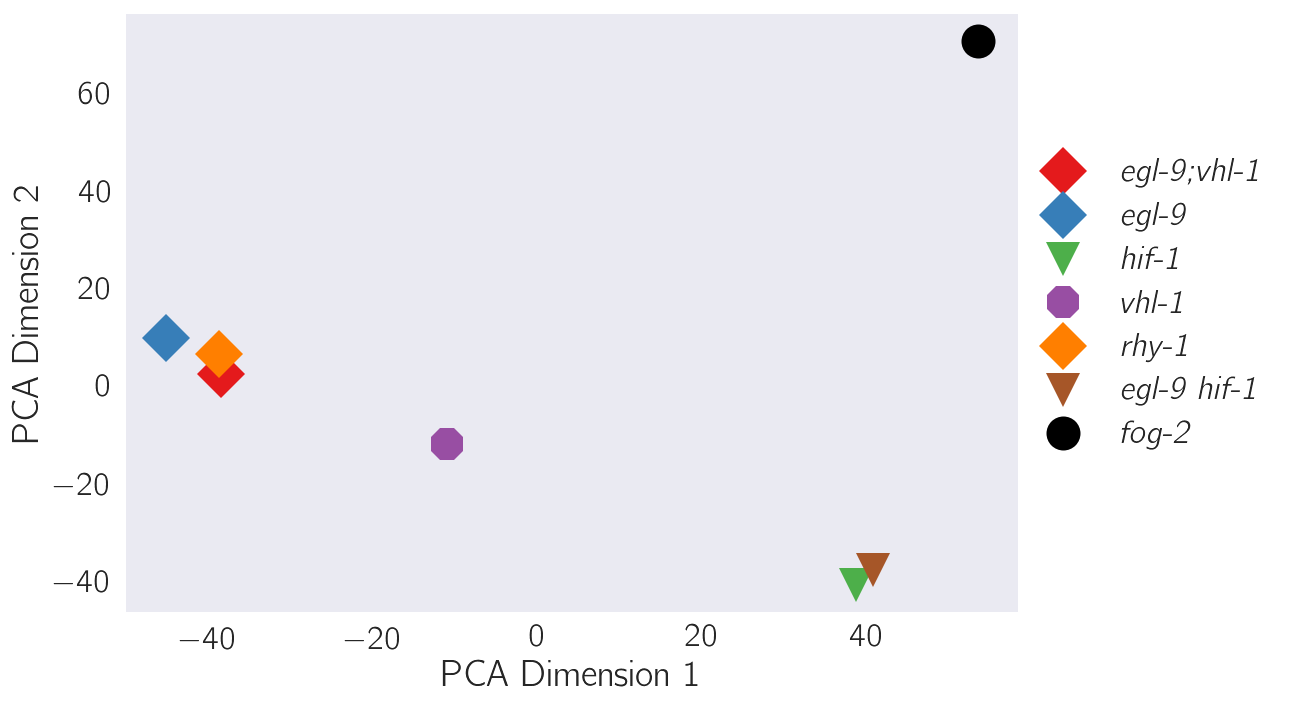

In [6]:
# initialize the PCA object and fit to the b-values
sklearn_pca = sklearn.decomposition.PCA(n_components=2).fit(bvals)
coords = sklearn_pca.fit(bvals).transform(bvals)

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628', 'k']
shapes = ['D', 'D', 'v', '8', 'D', 'v', 'o']

# go through each pair of points and plot them:
for i, array in enumerate(coords):
    l = genvar.fancy_mapping[labels[i]]
    plt.plot(array[0], array[1], shapes[i], color=colors[i], label=l, ms=17)

# plot prettify:
plt.legend(loc=(1, 0.25), fontsize=16)
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.savefig('../output/PCA_genotypes.svg', bbox_inches='tight')

We can see that the diamonds all cluster together and triangles cluster together. The triangles are HIF-1$^-$ genotypes, whereas the diamonds (and purple octagon) are HIF-1$^+$ genotypes. The *fog-2* mutant is far away from genes in this pathway. The closeness of the *egl-9;hif-1(lf)* mutant to the *hif-1* double mutant suggests to me that epistasis can be measured genome-wide. 

# Visualizing STPs

In [7]:
# the genotypes to compare
def find_overlap(genotypes, df, col='code', q=q):
    sig = tidy_data[(tidy_data[col].isin(letters)) & (tidy_data.qval < q)]
    grouped = sig.groupby('target_id')
    genes = []

    # find the intersection between the two.
    for target, group in grouped:
        # make sure the group contains all desired genotypes
        all_in = (len(group[col].unique()) == 2)
        if all_in:
            genes += [target]
    return genes

# extract a temporary dataframe with all the desired genes
letters = ['e', 'b']  # rhy-1 and egl-9
genes = find_overlap(letters, tidy_data)
temp = tidy_data[tidy_data.target_id.isin(genes)]

# split the dataframes and find the rank of each gene
ovx = genpy.find_rank(temp[temp.code == letters[0]])
ovy = genpy.find_rank(temp[temp.code == letters[1]])

In [8]:
# modify the sorting order just once to prettify the upcoming figure
sorter = gvars.genvars()
sorter.sort_muts['g'] = 10  # set to some large value so fog-2 is sorted last
sorter.sort_muts['c'] = 7  # set so hif-1 and egl-hif show up together
sorter.sort_muts['f'] = 8  # set so hif-1 and egl-hif show up together

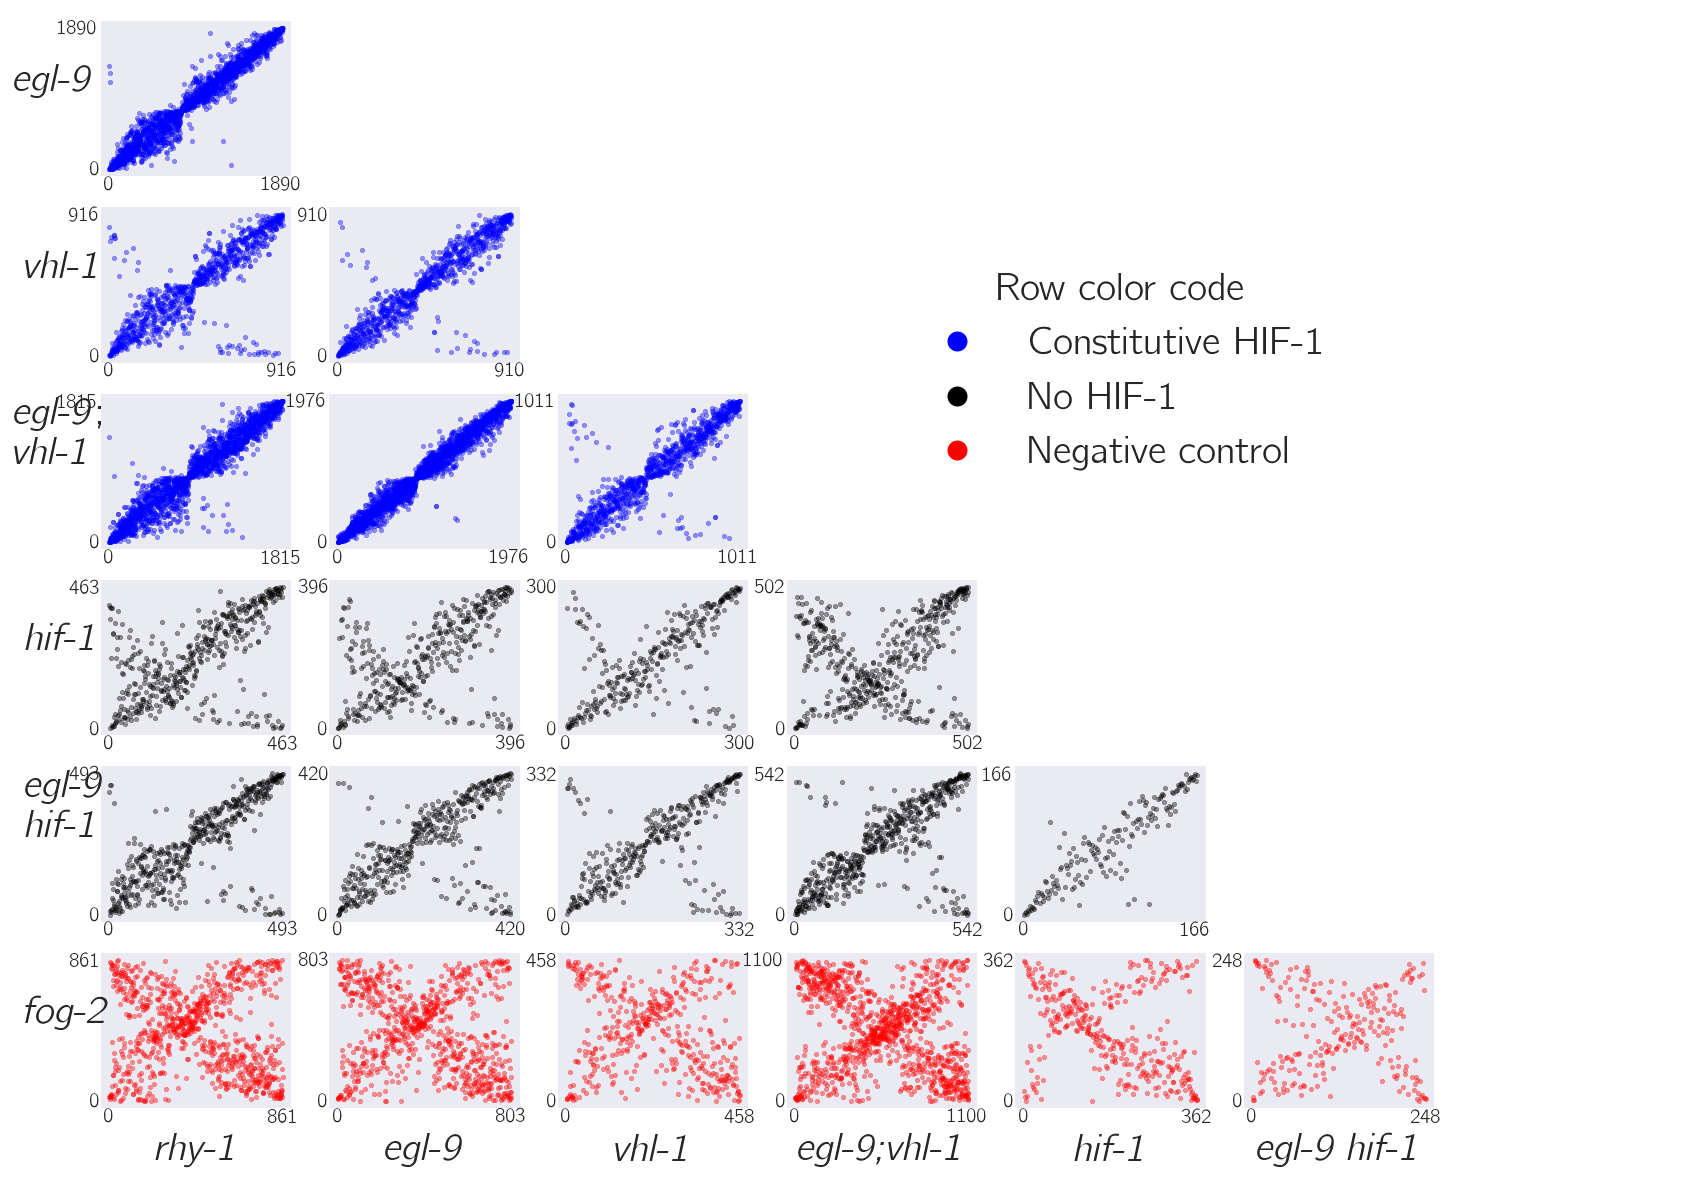

In [9]:
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
rc = {'axes.labelsize': 20}
sns.set_context('notebook', rc=rc)

nplots = len(tidy_data.code.unique())
fig, ax = plt.subplots(nrows=nplots-1, ncols=nplots, figsize=(14,10))

tidy_data['sort'] = tidy_data.code.map(sorter.sort_muts)
tidy_data.sort_values('sort', inplace=True)

for col, a in enumerate(tidy_data.fancy_genotype.unique()):
    for j, b in enumerate(tidy_data.fancy_genotype.unique()[col+1:]):
        row = col + j
        letters = [a, b]
        genes = find_overlap(letters, tidy_data, col='fancy_genotype')
        if len(genes) == 0:
            raise ValueError('list is empty')
        temp = tidy_data[tidy_data.target_id.isin(genes)]

        # split the dataframes and find the rank of each gene
        ovx = genpy.find_rank(temp[temp.fancy_genotype == letters[0]])
        ovy = genpy.find_rank(temp[temp.fancy_genotype == letters[1]])
        
        # plot
        if b == '\\emph{egl-9 hif-1}' or b == '\\emph{hif-1}':
            ax[row, col].scatter(ovx.r, ovy.r, s=5, alpha=0.4, color='k')
        elif b != '\\emph{fog-2}':
            ax[row, col].scatter(ovx.r, ovy.r, s=5, alpha=0.4, color='blue')
        else:
            ax[row, col].scatter(ovx.r, ovy.r, s=5, alpha=0.4, color='red')

        # set row labels
        ylabel = b.replace(' ', '}\n\emph{').replace(';', '};\n\emph{')
        ax[row, 0].set_ylabel(ylabel, rotation=0, labelpad=22,
                              horizontalalignment='left')

        # remove tick labels for cleanliness
        ax[row, col].xaxis.set_ticks([0, ovx.r.max()])
        ax[row, col].yaxis.set_ticks([0, ovx.r.max()])
        ax[row, col].tick_params(axis='both', which='major', pad=.2)

    # set column labels
    ax[nplots-2, col].set_xlabel(a)

# remove upper triangle plots
for row in range(nplots+1):
    for col in range(row, nplots):
        if col > row:
            ax[row, col].axis('off')

# add a legend:
texts = ["Constitutive HIF-1", "No HIF-1",
         'Negative control']
types = ['bo', 'ko', 'ro']
patches = [plt.plot([], [], types[i], ms=10, ls="",
           label="{:s}".format(texts[i]))[0] for i in range(len(types))]

# adjust legend size:
mpl.rcParams['legend.fontsize'] = 20

# draw legend
legend = plt.legend(handles=patches, loc=(-3, 4), ncol=1, numpoints=1, title='Row color code')
plt.setp(legend.get_title(), fontsize='20')

# plt.savefig('../output/rank_plots/triangle_plot.svg', bbox_inches='tight')

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16